In [1]:
import requests
import numpy as np

LLAMAFILER_API = "http://localhost:8080"
EMBEDDING_DIMENSIONS = 384

# from sentence_transformers import SentenceTransformer
# def make_embedding_transformers(content: str):
#     # configuração do modelo Stella
#     query_prompt_name = "s2p_query"
# 
#     model = SentenceTransformer("dunzhang/stella_en_1.5B_v5", trust_remote_code=True).cuda()
#     embeddings = model.encode([content])
# 
#     return embeddings.loc[0]

def make_embedding_llama(content: str):
    response = requests.post(LLAMAFILER_API + "/embedding", json={"content": content})
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Get the "embedding" field and convert it to a numpy array
        embedding = np.array(data["embedding"])

        return embedding
    else:
        print("Failed to retrieve data")
        raise AssertionError("Resposta inválida")


def make_embedding(content: str):
    return make_embedding_llama(content)

In [2]:
import json
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

def create_embeds():
    SENTIMENT_INOFF = 0
    SENTIMENT_OFF = 1

    def load_json(path):
        with open(path, "r") as f:
            return json.load(f)

    # carregar todos os dados
    sentiment_inoff_rows = load_json("../0_SyntheticDatasetMaker/output_processed.json")
    sentiment_off_rows = load_json("../Dataset/OffensiveTweets.json")
    toxic_conversations_toxic = pd.read_csv("../Dataset/SetFit toxic_conversations Subset Toxic_4k.csv")["text"].values.tolist()
    toxic_conversations_nottoxic = pd.read_csv("../Dataset/SetFit toxic_conversations Subset NotToxic_7k.csv")["text"].values.tolist()

    all_data_off = sentiment_off_rows + toxic_conversations_toxic
    all_data_inoff = sentiment_inoff_rows + toxic_conversations_nottoxic

    print(len(all_data_off), len(all_data_inoff))

    values = []

    for tweet in tqdm(all_data_off):
        embedding = make_embedding(tweet)
        values.append([tweet, SENTIMENT_OFF] + list(embedding))
  
    for tweet in tqdm(all_data_inoff):
        embedding = make_embedding(tweet)
        values.append([tweet, SENTIMENT_INOFF] + list(embedding))


    # preparar dataframe para armazenar os embeddings
    df = pd.DataFrame(values, columns=["content", "sentiment"] + [f"d{i}" for i in range(0, EMBEDDING_DIMENSIONS)])
    
    with open("./embeddings.dat", "wb") as f:
        pickle.dump(df, f)
    
    return df

df = create_embeds()

7895 8110


  0%|          | 0/7895 [00:00<?, ?it/s]

  0%|          | 0/8110 [00:00<?, ?it/s]

Logistic Regression:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      1624
           1       0.80      0.79      0.79      1577

    accuracy                           0.80      3201
   macro avg       0.80      0.79      0.79      3201
weighted avg       0.80      0.80      0.80      3201

[[1305  319]
 [ 337 1240]]

Decision Tree:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      1624
           1       0.62      0.65      0.63      1577

    accuracy                           0.63      3201
   macro avg       0.63      0.63      0.63      3201
weighted avg       0.63      0.63      0.63      3201

[[1002  622]
 [ 559 1018]]

Random Forest:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1624
           1       0.77      0.73      0.75      1577

    accuracy                           0.76      3201
   macro avg       0.

/home/lucas/Src/@UniSENAI/T1_Grupo_1/SentimentAnalysis/2_Help/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1624
           1       0.81      0.78      0.79      1577

    accuracy                           0.80      3201
   macro avg       0.80      0.80      0.80      3201
weighted avg       0.80      0.80      0.80      3201

[[1326  298]
 [ 343 1234]]



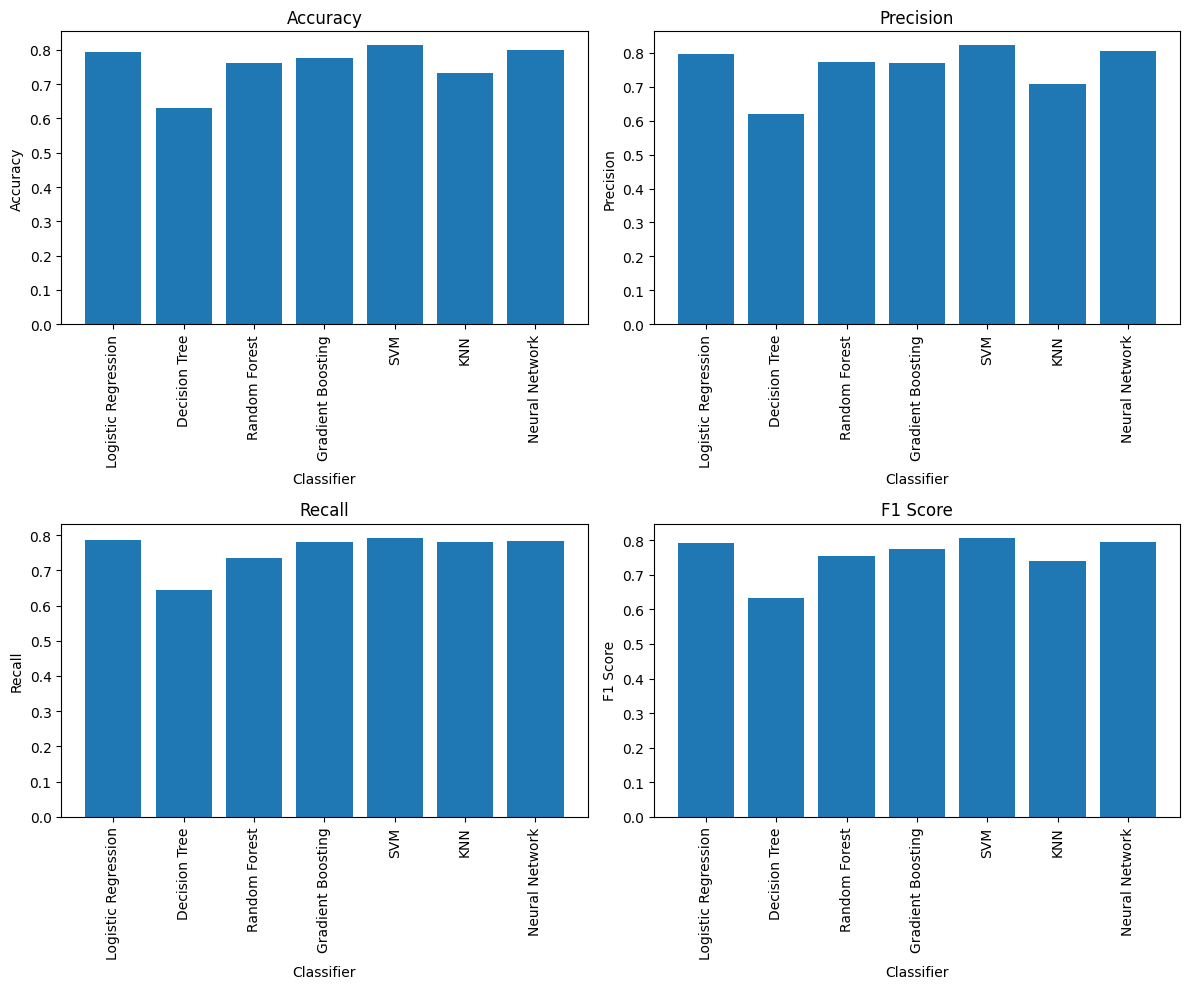

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pickle

f = open("./embeddings.dat","rb")
df = pickle.load(f)
f.close()

X = df.iloc[:, 2:] # dataframe contendo as colunas após a segunda
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Define the classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(10,))
}

# Train and test the classifiers
results = {
    'Accuracy': {},
    'Precision': {},
    'Recall': {},
    'F1 Score': {}
}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train.values.ravel())

    with open(f"./models/{name}.pickle", "wb") as mf:
        pickle.dump(clf, mf)
        
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    results['Accuracy'][name] = accuracy
    results['Precision'][name] = precision
    results['Recall'][name] = recall
    results['F1 Score'][name] = f1
    print(f"{name}:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print()

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].bar(results['Accuracy'].keys(), results['Accuracy'].values())
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_xlabel('Classifier')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].tick_params(axis='x', rotation=90)

axs[0, 1].bar(results['Precision'].keys(), results['Precision'].values())
axs[0, 1].set_title('Precision')
axs[0, 1].set_xlabel('Classifier')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].tick_params(axis='x', rotation=90)

axs[1, 0].bar(results['Recall'].keys(), results['Recall'].values())
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Classifier')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].tick_params(axis='x', rotation=90)

axs[1, 1].bar(results['F1 Score'].keys(), results['F1 Score'].values())
axs[1, 1].set_title('F1 Score')
axs[1, 1].set_xlabel('Classifier')
axs[1, 1].set_ylabel('F1 Score')
axs[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.savefig('classifier_comparison.png')

In [83]:
import pickle
import os
import pandas as pd

def classify(content: str):
    results = {}
    
    for filePath in os.listdir("./models"):
        if not filePath.endswith(".pickle"):
            continue

        embeddings = make_embedding(content)

        X = pd.DataFrame(columns=[f"d{i}" for i in range(0, EMBEDDING_DIMENSIONS)])
        X.loc[0] = embeddings;


        with open(f"./models/{filePath}", "rb") as f:
            model = pickle.load(f)
            
            y = model.predict(X)[0]
            results[filePath.replace(".pickle", "")] = str(y);

    return results

#classify("I love strawberries")
#classify("Artificial Intelligence is bad and should be exterminated")
classify("trump vs obama in a physical fight. who wins?")

{'SVM': '0',
 'Gradient Boosting': '0',
 'Neural Network': '0',
 'Logistic Regression': '0',
 'Random Forest': '0',
 'Decision Tree': '1',
 'KNN': '1'}

In [ ]:
from http.server import BaseHTTPRequestHandler, HTTPServer
import json

class RequestHandler(BaseHTTPRequestHandler):
    def do_POST(self):
        if self.path != '/classify':
            self.send_response(404)
            self.end_headers()
            return

        content_length = int(self.headers['Content-Length'])
        body = self.rfile.read(content_length)
        try:
            data = json.loads(body)
            prompt = data.get('prompt')

            if prompt is None:
                self.send_response(400)
                self.send_header("Content-Type", "application/json")
                self.end_headers()
                self.wfile.write(b'{"error": "Missing prompt"}')
                return

            # Simple classification model
            result = classify(prompt)

            self.send_response(200)
            self.send_header("Content-Type", "application/json")
            self.end_headers()
            self.wfile.write(json.dumps(result).encode())
        except json.JSONDecodeError:
            self.send_response(400)
            self.send_header("Content-Type", "application/json")
            self.end_headers()
            self.wfile.write(b'{"error": "Invalid JSON"}')

def run_server():
    server_address = ('', 8000)
    httpd = HTTPServer(server_address, RequestHandler)
    print('Server running on port 8000...')
    httpd.serve_forever()

if __name__ == '__main__':
    run_server()
